In [2]:
from fastai.data.all import *
from fastai.vision.all import *
import torch
import ipywidgets as widgets
from fastai.vision.widgets import *

In [3]:
path = untar_data(URLs.MNIST)
path

Path('D:/Users/anupam/.fastai/data/mnist_png')

In [4]:
db_mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                    get_items=get_image_files,
                    splitter=GrandparentSplitter(train_name="training", valid_name="testing"),
                    get_y=parent_label)

In [5]:
# calculate the mean and std dev of training image data
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_train = [to_tensor(img) for img, label in db_mnist.datasets(path/'training')]
img_train_stack = torch.stack(img_train, dim=3)
img_train_stack_1d = img_train_stack.view(1, -1)
img_mean = img_train_stack_1d.mean(dim=1)
img_stdev = img_train_stack_1d.std(dim = 1)
print(f"Mean = {img_mean}, Std. dev. = {img_stdev}")

Mean = tensor([0.1307]), Std. dev. = tensor([0.3081])


In [6]:
import os
os.getcwd()

'd:\\Anupam_Technical\\Code\\ML\\DeepLearning\\fastai\\MnistPlayground'

In [7]:
from torchvision import datasets

data_path = "./dataset"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize(img_mean, img_stdev)])

train_mnist = datasets.MNIST(data_path, train=True, download=False, transform = data_transform)
val_mnist = datasets.MNIST(data_path, train=False, download=False, transform=data_transform)
img_to_1d_tensor = Transform(lambda img: img.view(img.shape[0], -1))
#train_dl = TfmdDL(train_mnist, device=device, shuffle=True)
dls = DataLoaders.from_dsets(train_mnist, val_mnist, device=device)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [8]:
img, label = dls.one_batch()
print(label.shape)
print(img.shape)

torch.Size([64])
torch.Size([64, 1, 28, 28])


In [9]:
# Approach 2
# create a data block with the required transforms in place
norm_tfm = Normalize.from_stats(img_mean, img_stdev)

db_mnist_norm = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                    get_items=get_image_files,
                    splitter=GrandparentSplitter(train_name="training", valid_name="testing"),
                    get_y=parent_label,
                    batch_tfms=norm_tfm)

dl_mnist = db_mnist_norm.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


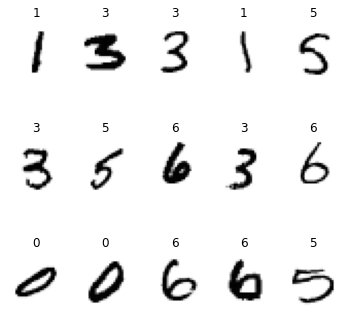

In [10]:
dl_mnist.show_batch(max_n=15, figsize=(6,6))

In [21]:
imgs, labels = dl_mnist.one_batch()
print(imgs.shape, labels.shape)
flt = Flatten()
flt(imgs).shape    

torch.Size([64, 1, 28, 28]) torch.Size([64])


torch.Size([64, 784])

In [36]:
import torch.nn as nn
import torch.optim as optim

mnist_model = nn.Sequential(Flatten(),
                      nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim = 1))

print(mnist_model)
learning_rate = 0.01
# define the optimizer ( we choose mini batch gradient descent with momentum)
optimizer = optim.SGD(mnist_model.parameters(), lr=learning_rate, momentum=0.9)
# loss function
mnist_loss_fn = nn.NLLLoss()


Sequential(
  (0): Flatten(full=False)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
  (6): LogSoftmax(dim=1)
)


In [38]:
mnist_learner = Learner(dls, mnist_model, loss_func=mnist_loss_fn, opt_func=SGD, lr=learning_rate, 
                        metrics=accuracy)

mnist_learner.fit(n_epoch=10, lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,time
0,0.276147,0.266927,0.921900,01:34
1,0.246996,0.229313,0.933600,01:24
2,0.200733,0.200087,0.941300,01:26
3,0.196840,0.177466,0.947100,01:25
4,0.155816,0.162117,0.952400,01:36
5,0.146193,0.146855,0.955400,01:31
6,0.127331,0.135241,0.958100,01:36
7,0.127802,0.123932,0.961200,01:25
8,0.105469,0.117927,0.964000,01:31
